In [1]:
from google.colab import drive
drive.mount('/content/drive')$

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline
import sys 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python'))
                  #.loc[lambda df: df['race'].isin(['White', 'Black'])])
    input_data = pd.concat([input_data, pd.read_csv('http://grarivincent.com/old/adult.test', names=column_names, na_values="?", sep=r'\s*,\s*', engine='python').loc[1:,:] ])

    input_data[['age','fnlwgt','education_num','capital_gain', 'capital_loss', 'hours_per_week']] = input_data[['age','fnlwgt','education_num','capital_gain', 'capital_loss', 'hours_per_week']].astype(int)
    
    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(sex=lambda df: (df['sex'] == 'Male').astype(int)))
    # targets; 1 when someone makes over 50k , otherwise 0
    y = input_data['target'].replace({'<=50K.': 0, '>50K.': 1, '>50K': 1, '<=50K': 0 })
    XNC = input_data.loc[:, ['race','age','country']]
    XNC = XNC.assign(race=lambda df: (df['race'] == 'White').astype(int))
    print(XNC.shape)
    XNC = (XNC
           .fillna('Unknown')
           .pipe(pd.get_dummies, columns = ['country'], drop_first=True))
    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target','race','age','sex','country'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, columns = ['workclass', 'education', 
                    'marital_status', 'occupation', 'relationship'], drop_first=True))

    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"features X_NC: {XNC.shape[0]} samples, {XNC.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, XNC, y, Z

# load ICU data set
X, XNC, y, S = load_ICU_data('http://grarivincent.com/old/adult.data')


(48841, 3)
features X: 48841 samples, 53 attributes
features X_NC: 48841 samples, 43 attributes
targets y: 48841 samples
sensitives Z: 48841 samples, 1 attributes


In [3]:
XNC

,race,age,country_Canada,country_China,country_Columbia,country_Cuba,country_Dominican-Republic,country_Ecuador,country_El-Salvador,country_England,country_France,country_Germany,country_Greece,country_Guatemala,country_Haiti,country_Holand-Netherlands,country_Honduras,country_Hong,country_Hungary,country_India,country_Iran,country_Ireland,country_Italy,country_Jamaica,country_Japan,country_Laos,country_Mexico,country_Nicaragua,country_Outlying-US(Guam-USVI-etc),country_Peru,country_Philippines,country_Poland,country_Portugal,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Unknown,country_Vietnam,country_Yugoslavia
0,1,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,28,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,1,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16277,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16278,1,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16279,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [4]:
X

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,77516,13,2174,0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,83311,13,0,0,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,215646,9,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,234721,7,0,0,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,338409,13,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,215419,13,0,0,36,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
16277,321403,9,0,0,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
16278,374983,13,0,0,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
16279,83891,13,5455,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [5]:
# split into train/test set
X_train, X_test, XNC_train, XNC_test, y_train, y_test, S_train, S_test = train_test_split(X, XNC, y, S, test_size=0.2, random_state=7)

# standardize the data
scaler = MinMaxScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

scalerNC = MinMaxScaler().fit(XNC_train)
scale_dfNC = lambda df, scaler: pd.DataFrame(scalerNC.transform(df), columns=df.columns, index=df.index)

X_train, X_test = X_train.pipe(scale_df, scaler), X_test.pipe(scale_df, scaler)
XNC_train, XNC_test = XNC_train.pipe(scale_dfNC, scaler), XNC_test.pipe(scale_dfNC, scaler)
X_train, X_test, XNC_train, XNC_test, y_train, y_test = X_train.values, X_test.values, XNC_train.values, XNC_test.values, y_train.values, y_test.values

S_train, S_test =S_train.values, S_test.values

In [6]:
X_train.shape

(39072, 53)

In [7]:
XNC_train.shape

(39072, 43)

In [8]:
53+43+1

97

In [9]:
X_train

array([[0.0948343 , 0.8       , 0.14344143, ..., 0.        , 1.        ,
        0.        ],
       [0.09831035, 0.6       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.35573281, 0.8       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11796308, 0.6       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.0704316 , 0.8       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14809064, 0.53333333, 0.        , ..., 0.        , 0.        ,
        0.        ]])

HGR

In [10]:

import torch
import torch.nn as nn
import torch.nn.functional as F
H = 15
H2 = 15

class Net_HGR(nn.Module):
    def __init__(self):
        super(Net_HGR, self).__init__()
        self.fc1 = nn.Linear(3, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4

class Net2_HGR(nn.Module):
    def __init__(self):
        super(Net2_HGR, self).__init__()
        self.fc1 = nn.Linear(43, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    

class HGR_NN(nn.Module):
    
    def __init__(self,model_F,model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var,nb):
      
        for j in range(nb) :

            pred_F  = self.mF(yhat.detach())
            pred_G  = self.mG(y2_var.detach())
           
            epsilon=0.0001 
            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
            pred_F_norm[torch.isnan(pred_F_norm )] = 0
            pred_G_norm[torch.isnan(pred_G_norm )] = 0

            ret = torch.mean(pred_F_norm*pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            #print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret



# Variational Autoencoder

In [11]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
batch_size=128
epochs=10
seed=1
log_interval=10
device = torch.device("cuda")
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #self.fc1NC = nn.Linear(97, 400)  # La dimension de la data est de 94 variables et on rajoute la variable sensible A pour construire l'espace latent U
        #self.fc21NC = nn.Linear(400, 20) # ici c'est pour la moyenne on part sur 20 neurones en deuxiemes couches
        #self.fc22NC = nn.Linear(400, 20) # ici c'est pour les écarts types avec toujours 20 neurones sur la deuxieme couche
 
        self.fc1S = nn.Linear(97, 400)  # La dimension de la data est de 94 variables et on rajoute la variable sensible A pour construire l'espace latent U
        self.fc21S = nn.Linear(400, 3) # ici c'est pour la moyenne on part sur 20 neurones en deuxiemes couches
        self.fc22S = nn.Linear(400, 3) # ici c'est pour les écarts types avec toujours 20 neurones sur la deuxieme couche

        self.fc3I = nn.Linear(43+3, 400) # ici c'est la partie decodeur
        self.fc4I = nn.Linear(400, 53) # on revient sur une data sur le nombre de variables de X
        #self.fc42NC = nn.Linear(400, 1) # on prédit uniquement Y => donc une seule colonne

        self.fc3Y = nn.Linear(96+3 , 400) # ici c'est la partie decodeur
        self.fc41Y = nn.Linear(400, 1) # on revient sur une data sur le nombre de variables de X


    def encodeS(self, x, xNC, y) :
        h1 = F.relu(self.fc1S(torch.cat([xNC.view(-1, 43),x.view(-1, 53),y.view(-1, 1)],1)))  # on utilise une simple ReLu pour la premiere couche de 400 neurones et ID pour la deuxieme couche pour u et std
        return self.fc21S(h1), self.fc22S(h1)

    #def encodeI(self, x, xNC, y, a, S) :
    #    h1 = F.relu(self.fc1I(torch.cat([xNC.view(-1, 43),S],1)))  # on utilise une simple ReLu pour la premiere couche de 400 neurones et ID pour la deuxieme couche pour u et std
    #    return self.fc21I(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # racine de la variance ==> std
        eps = torch.randn_like(std)   # une loi normal entre 0 et 1 avec une taille de std soit de 20 !!
        #eps =1
        return mu + eps*std  # z = u + sigm * eps

    def decodeI(self,  x, xNC, y, S):
        h3 = F.relu(self.fc3I(torch.cat([xNC.view(-1, 43),S],1))) # la 3eme couche et donc la premiere couche du decoder a une relu avec 400 neurones 
        return torch.sigmoid(self.fc4I(h3))#, torch.sigmoid(self.fc42NC(h3)) # la 4 eme couche et dernier on souhaite retrouver une data on met une sigmoid car on a quelque chose entre . et 1

    def decodeY(self,  x, xNC, y, S, XIrec):
        #print(torch.cat([xNC.view(-1, 43),XIrec.view(-1, 53), S],1).shape)
        h3 = F.relu(self.fc3Y(torch.cat([xNC.view(-1, 43),x.view(-1, 53), S],1))) # la 3eme couche et donc la premiere couche du decoder a une relu avec 400 neurones 
        return torch.sigmoid(self.fc41Y(h3)) # la 4 eme couche et dernier on souhaite retrouver une data on met une sigmoid car on a quelque chose entre . et 1

    def forward(self, x, xNC, y):
        muS, logvarS = self.encodeS(x, xNC, y)  # on recupere le X et on obtient le u et la logvar qui va nous servir à calculer z en reparameterize trick
        S = self.reparameterize(muS, logvarS) # en deuxieme couche une fois qu on recupere u et sigma on utilise une loi normal entre 0 et 1 u + sigmaµ eps
        recon_XI_batch = self.decodeI(x, xNC, y, S)
        recon_Y_batch = self.decodeY(x, xNC, y,  S, recon_XI_batch)

        #mu1, logvar1 = self.encode(x.view(-1, 94), a)  # on recupere le X et on obtient le u et la logvar qui va nous servir à calculer z en reparameterize trick
        #z1 = self.reparameterize(mu1, logvar1) # en deuxieme couche une fois qu on recupere u et sigma on utilise une loi normal entre 0 et 1 u + sigmaµ eps
        #mu0, logvar0 = self.encode(x.view(-1, 94), a)  # on recupere le X et on obtient le u et la logvar qui va nous servir à calculer z en reparameterize trick
        #z0 = self.reparameterize(mu0, logvar0) # en deuxieme couche une fois qu on recupere u et sigma on utilise une loi normal entre 0 et 1 u + sigmaµ eps
        return  recon_XI_batch, S, recon_Y_batch, muS, logvarS # on decode ici pour retrouver une image ici


class Demographic(nn.Module):
    def __init__(self):
        super(Adversarial, self).__init__()
        self.adv_fc1 = nn.Linear(44, 6)
        self.adv_fc2 = nn.Linear(6, 2)
        self.adv_fc3 = nn.Linear(2, 1)

    def forward(self, x):
        x = self.adv_fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc2(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc3(x)
        x = F.sigmoid(x)
        return x
   

class Adversarial(nn.Module):
    def __init__(self):
        super(Adversarial, self).__init__()
        self.adv_fc1 = nn.Linear(20, 6)
        self.adv_fc2 = nn.Linear(6, 2)
        self.adv_fc3 = nn.Linear(2, 2)

    def forward(self, x):
        x = self.adv_fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc2(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc3(x)
        x = F.relu(x)
        return x
   
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    tiled_x = x.unsqueeze(1).repeat(1, y_size, 1)
    tiled_y = y.unsqueeze(0).repeat(x_size, 1, 1)
    #print('x', x)
    #print('x', y)
    #print('xshape', x.shape)
    #print('yshapbinary_cross_entropy', y.shape)
    #print('tiled_x',tiled_x)
    #print('tiled_y',tiled_y)
    return ((-(tiled_x - tiled_y) ** 2).mean(dim=2) / float(dim)).exp_()

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd


In [12]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from sklearn.utils import shuffle
from torch.autograd import Variable

latent_dim=3
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

mF = Net_HGR().cuda()
mG = Net2_HGR().cuda()
optimizer_F = optim.Adam(mF.parameters(), lr=1e-4)
optimizer_G = optim.Adam(mG.parameters(), lr=1e-4)
epsilon=0.0001

betaX = 1.5
betammd = 0.1
betahgr = 0.2

batch_idx=0
batch_size=2000
epochs=150
epochs_hgr=50
seed=1
log_interval=1
batch_no = len(X_train) // batch_size

for epoch in range(epochs):

  x_train, x_trainNC, ytrain, senstrain = shuffle(X_train, XNC_train , np.expand_dims(y_train,axis = 1), S_train)
  
  average_total_loss = 0
  average_lossX = 0
  average_mmd = 0
  average_lossY = 0
  average_mmdS = 0
  average_hgr = 0
  betahgr2=0
  # Mini batch learning  
  for i in range(batch_no):
    
    start = i * batch_size
    end = start + batch_size
    x_var = Variable(torch.FloatTensor(x_train[start:end])).cuda()
    x_varNC = Variable(torch.FloatTensor(x_trainNC[start:end])).cuda()
    y_var = Variable(torch.FloatTensor(ytrain[start:end])).cuda()
    s_var = Variable(torch.FloatTensor(senstrain[start:end])).cuda()
    recon_x, S, recon_y, mu, logvar = model(x_var, x_varNC, y_var)
    
    #if (epoch ==10) & (i<5) :
    #  for k in range(400) :
    #    optimizer_F.zero_grad()
    #    optimizer_G.zero_grad()
    #    
    #    pred_F  = mF(s_var.detach())
    #    pred_G  = mG(z.view(-1, latent_dim).detach())
    #    pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
    #    pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))

    #    ret = torch.mean(pred_F_norm*pred_G_norm)
    #    loss_HGR = - ret  # maximize
    #    loss_HGR.backward()

    #    optimizer_F.step()
    #    optimizer_G.step()

    if epoch > 30 :
      betahgr2=betahgr
      for k in range(epochs_hgr):
        
        optimizer_F.zero_grad()
        optimizer_G.zero_grad()
        
        pred_F  = mF(S.detach().cuda())
        pred_G  = mG(x_varNC.detach().cuda()) #,x_var.detach().cuda(),y_var.detach().cuda()],1))
        pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
        pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))

        ret = torch.mean(pred_F_norm*pred_G_norm)
        loss_HGR = - ret  # maximize
        loss_HGR.backward()

        optimizer_F.step()
        optimizer_G.step()


    optimizer.zero_grad()
    recon_XI, S, recon_y, mu, logvar = model(x_var, x_varNC, y_var)
    lossX = F.binary_cross_entropy(recon_XI, x_var.view(-1, 53), reduction='mean')
    lossY = F.binary_cross_entropy(recon_y, y_var.view(-1, 1), reduction='mean')

    #lossXNC = F.binary_cross_entropy(recon_xNC, x_varNC.view(-1, 43), reduction='mean')

    true_samplesS = Variable(
               torch.randn(x_var.shape[0], 1),
                requires_grad=False
            ).to(device)
    mmdS = compute_mmd(true_samplesS, S)

    #mmd =0
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    ### Training the adversary for epochs_adv epochs
    
    pred_F  = mF(S)
    pred_G  = mG(x_varNC)
    pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
    pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
    ret = torch.mean(pred_F_norm*pred_G_norm)
    loss = betaX*lossX + betaX*lossY + betammd*mmdS + betahgr2*ret
    loss.backward()
    optimizer.step()

    ## Average losses on the whole data
    average_total_loss += loss.item()
    average_lossX += lossX.item()
    average_lossY += lossY.item()
    average_mmdS += mmdS.item()
    average_hgr += ret.item()
    
  if epoch % log_interval == 0:
    print('====> Epoch: {} Total loss: {:.4f} || Loss X: {:.4f} || Loss Y: {:.4f} || HGR: {:.4f} || HGR: {:.4f} '.format(epoch, average_total_loss / batch_no, average_lossX / batch_no, average_lossY/ batch_no, average_mmd / batch_no, average_hgr / batch_no ))#,'MSE :', np.mean((y_train - recon_Y_batch.detach().numpy())**2))


====> Epoch: 0 Total loss: 1.7262 || Loss X: 0.5546 || Loss Y: 0.5659 || HGR: 0.0000 || HGR: 0.0006 
====> Epoch: 1 Total loss: 1.1645 || Loss X: 0.2971 || Loss Y: 0.4441 || HGR: 0.0000 || HGR: -0.0030 
====> Epoch: 2 Total loss: 0.8701 || Loss X: 0.2491 || Loss Y: 0.2959 || HGR: 0.0000 || HGR: -0.0008 
====> Epoch: 3 Total loss: 0.5617 || Loss X: 0.2298 || Loss Y: 0.1003 || HGR: 0.0000 || HGR: 0.0170 
====> Epoch: 4 Total loss: 0.4263 || Loss X: 0.2261 || Loss Y: 0.0107 || HGR: 0.0000 || HGR: 0.0319 
====> Epoch: 5 Total loss: 0.3969 || Loss X: 0.2175 || Loss Y: 0.0051 || HGR: 0.0000 || HGR: 0.0236 
====> Epoch: 6 Total loss: 0.3765 || Loss X: 0.2077 || Loss Y: 0.0034 || HGR: 0.0000 || HGR: 0.0238 
====> Epoch: 7 Total loss: 0.3597 || Loss X: 0.2001 || Loss Y: 0.0028 || HGR: 0.0000 || HGR: 0.0145 
====> Epoch: 8 Total loss: 0.3468 || Loss X: 0.1940 || Loss Y: 0.0018 || HGR: 0.0000 || HGR: 0.0116 
====> Epoch: 9 Total loss: 0.3365 || Loss X: 0.1886 || Loss Y: 0.0018 || HGR: 0.0000 || H

KeyboardInterrupt: ignored

In [ ]:
x_varNC.shape

torch.Size([2000, 43])

In [ ]:
torch.save(model.state_dict(), "WithoutDemographic_adult3_150and02" + str(betahgr),_use_new_zipfile_serialization=False)

In [13]:
!wget "http://grarivincent.com/research/individual/WithoutDemographic_adult3_150and020 (1).2"

--2021-03-14 07:59:00--  http://grarivincent.com/research/individual/WithoutDemographic_adult3_150and020%20(1).2
Resolving grarivincent.com (grarivincent.com)... 217.160.0.183, 2001:8d8:100f:f000::2ce
Connecting to grarivincent.com (grarivincent.com)|217.160.0.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 490416 (479K)
Saving to: ‘WithoutDemographic_adult3_150and020 (1).2’

WithoutDemographic_ 100%[===================>] 478.92K  --.-KB/s    in 0.09s   

2021-03-14 07:59:00 (5.19 MB/s) - ‘WithoutDemographic_adult3_150and020 (1).2’ saved [490416/490416]



In [14]:
model_VAE = VAE().to(device)
model_VAE.load_state_dict(torch.load("WithoutDemographic_adult3_150and020 (1).2"))

<All keys matched successfully>

In [ ]:
model = model_VAE

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
H = 15
H2 = 15
epochs_hgr=50

class Net_HGR(nn.Module):
    def __init__(self):
        super(Net_HGR, self).__init__()
        self.fc1 = nn.Linear(3, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


class Net2_HGR(nn.Module):
    def __init__(self):
        super(Net2_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


model_Net_F = Net_HGR()
model_Net_G = Net2_HGR()

class HGR_NN(nn.Module):
    
    def __init__(self,model_F,model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_Net_F
        self.mG = model_Net_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var,nb):
      
        for j in range(nb) :
            #ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
            #ret = torch.mean(pred_xy) - torch.mean(pred_x_y) - 0.25*torch.mean(torch.pow(pred_x_y,2))

            yhat2  =yhat.data.numpy()
            y2_var2=y2_var.data.numpy()
        
            yhat2_PT  = torch.from_numpy(yhat2).type(torch.FloatTensor)
            y2_var_PT = torch.from_numpy(y2_var2).type(torch.FloatTensor)

            pred_F  = self.mF(yhat2_PT)
            pred_G  = self.mG(y2_var_PT)

            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.std(pred_F)
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.std(pred_G)

            #epsilon=0.0000000000000000001
            epsilon=0.0001 
            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
            pred_F_norm[torch.isnan(pred_F_norm )] = 0
            pred_G_norm[torch.isnan(pred_G_norm )] = 0

            ret = torch.mean(pred_F_norm*pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            #print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret.data.numpy()


mF = Net_HGR().cuda()
mG = Net2_HGR().cuda()
optimizer_F = optim.Adam(mF.parameters(), lr=1e-4)
optimizer_G = optim.Adam(mG.parameters(), lr=1e-4)
epsilon=0.0001

batch_size = 512
num_epochs = 25
learning_rate = 0.0001
batch_no = len(X_train) // batch_size
#X_train_inv = recon_X_batch_a.data.numpy()
#Y_train_inv = recon_Y_batch_a.data.numpy()

from sklearn.utils import shuffle
from torch.autograd import Variable
criterionMSE = nn.MSELoss()
import math
nb_a=200
from torch.nn import functional as F
def sigmoid(x):
  output = [1 / (1 + math.exp(-x)) for x in x]
  return output

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(96, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x


model_Y = NN().cuda()
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer_Y = torch.optim.Adam(model_Y.parameters(), lr=0.001)
criterion_ADV =  nn.MSELoss()
#A0 = sensitive.mean() + sensitive.std()*Variable(torch.randn(data.shape[0]*nb_a, 1),requires_grad=False)
#recon_X_batch_a0, z_a0, recon_Y_batch_a0, mu_a0, logvar_a0 = model(data.repeat(nb_a,1).view(-1, 33),A0)
#recon_x, recon_xNC, S, U,  recon_y, mu, logvar = model(x_var, x_varNC, y_var,s_var)
from sklearn.metrics import accuracy_score
X_trainCUDA = Variable(torch.FloatTensor(X_train)).cuda()
XNC_trainCUDA = Variable(torch.FloatTensor(XNC_train)).cuda()
y_trainCUDA = Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).cuda()

X_testCUDA = Variable(torch.FloatTensor(X_test)).cuda()
XNC_testCUDA = Variable(torch.FloatTensor(XNC_test)).cuda()
y_testCUDA = Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).cuda()
table = [0,0,0,0,0,0]
for epoch in range(num_epochs):
    #if epoch % 50 != 0:
        #x_train = Variable(torch.FloatTensor(X_train.values),requires_grad=True)
        #x_test = Variable(torch.FloatTensor(X_test.values),requires_grad=True)
        #print('Epoch {}'.format(epoch+1))
        
        #y_predX= model(x_train).data.numpy().T
        #y_predXinv= model(recon_X_batch_a0).data.numpy().T

        #accuracy = (y_train-np.squeeze(y_predX)).pow(2).sum()     
        #accuracycount = accuracy_score(Y_train_inv.squeeze(1), np.squeeze(y_predXinv))
        #print ("Train Accuracy:", accuracy)#,"Train Accuracy Count:", accuracycount, "CLP:", np.mean(logit_y_predX-logit_y_predXinv)**2)
    x_train, x_trainNC, ytrain, sens_train = shuffle(X_train, XNC_train, np.expand_dims(y_train,axis = 1),  S_train)

    #A = s_var.mean() + s_var.std()*Variable(torch.randn(batch_size*nb_a, 1),requires_grad=False)
    # Mini batch learning
    for i in range(batch_no):
        print('Epoch: ', epoch, 'Batch:',i)
        start = i * batch_size
        end = start + batch_size

        x_var = Variable(torch.FloatTensor(x_train[start:end])).cuda()
        xNC_var = Variable(torch.FloatTensor(x_trainNC[start:end])).cuda()
        y_var = Variable(torch.FloatTensor(ytrain[start:end])).cuda()
        s_var = Variable(torch.FloatTensor(sens_train[start:end])).cuda()

        #recon_X_batch_a, z_a, recon_Y_batch_a, mu_a, logvar_a = model(x_var.repeat(nb_a,1).view(-1, 53),x_var.repeat(nb_a,1).view(-1, 33))
        recon_x, S, recon_y, mu, logvar = model(x_var.repeat(nb_a,1).view(-1, 53), xNC_var.repeat(nb_a,1).view(-1, 43), y_var.repeat(nb_a,1).view(-1, 1))

        #ypredcontworld = model_Y(torch.cat([recon_xNC.view(-1, 43),recon_x.view(-1, 53)],1))
        ypredcontworld = model_Y(torch.cat([x_var.view(-1, 53),xNC_var.view(-1, 43)],1))
        lossX_inv = criterion(ypredcontworld, y_var)

        ypred2= ypredcontworld.detach()

        if epoch ==0:
          for l in range(10):
            ypred_var = model_Y(torch.cat([xNC_var.view(-1, 43),x_var.view(-1, 53)],1))
            lossY =criterion(ypred_var, y_var)
            loss = lossY #+betamse*ret # + lossX_inv -2*lossX#+ betamse*MSEcount
            print('loss tot', loss, 'loss Y', lossY)
            loss.backward()
            optimizer_Y.step()
        #S=s_var.repeat(nb_a,1).view(-1, 1)
        ypred_var2 = model_Y(torch.cat([xNC_var.repeat(nb_a,1).view(-1, 43),x_var.repeat(nb_a,1).view(-1, 53)],1))

        for k in range(epochs_hgr):
          
          optimizer_F.zero_grad()
          optimizer_G.zero_grad()
          
          pred_F  = mF(S.detach().cuda())
          pred_G  = mG(ypred_var2.detach().cuda())
          pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
          pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))

          ret = torch.mean(pred_F_norm*pred_G_norm)
          loss_HGR = - ret  # maximize
          loss_HGR.backward()

          optimizer_F.step()
          optimizer_G.step()
        #Yhat_count =  Variable(torch.FloatTensor(ypred_var.data.numpy().T.repeat(nb_a,1).T))
        #MSEcount = (Yhat_count-ypredcontworld).pow(2).sum() 
        
        optimizer_Y.zero_grad()
        ypred_var = model_Y(torch.cat([xNC_var.view(-1, 43),x_var.view(-1, 53)],1))
        ypred_var2 = model_Y(torch.cat([xNC_var.repeat(nb_a,1).view(-1, 43),x_var.repeat(nb_a,1).view(-1, 53)],1))
        lossY =criterion(ypred_var, y_var)
        betamse =0.48 #7   ## LAMBDA =0.7
        pred_F  = mF(S)
        pred_G  = mG(ypred_var2)
        pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
        pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))

        ret = torch.mean(pred_F_norm*pred_G_norm)
        loss = lossY +betamse*ret # + lossX_inv -2*lossX#+ betamse*MSEcount

        if epoch ==0:
          loss = lossY  # + lossX_inv -2*lossX#+ betamse*MSEcount
        print('loss tot', loss, 'loss Y', lossY)
        print('HGR', ret)

        loss.backward()
        optimizer_Y.step()
        Ypred = torch.sigmoid(model_Y(torch.cat([XNC_trainCUDA.view(-1, 43),X_trainCUDA.view(-1, 53)],1)))>0.5
        Ho = (S_train==1)
        Fe = (S_train==0)
        odds=Ypred.float()[Ho].mean()/ Ypred.float()[Fe].mean()
        PRULE= min(odds, 1/odds)

        Ypredtest = torch.sigmoid(model_Y(torch.cat([XNC_testCUDA.view(-1, 43),X_testCUDA.view(-1, 53)],1)))>0.5
        Ho = (S_test==1)
        Fe = (S_test==0)
        odds=Ypredtest.float()[Ho].mean()/ Ypredtest.float()[Fe].mean()
        PRULEtest= min(odds, 1/odds)
        print('ACC Train',(Ypred==y_trainCUDA).sum()/X_train.shape[0], 'PRULE',PRULE, 'ACC Test',(Ypredtest==y_testCUDA).sum()/X_test.shape[0],'PRULEtest',PRULEtest)
        table = np.vstack([table,[(Ypred.cpu().data.numpy()==y_trainCUDA.cpu().data.numpy()).sum()/X_train.shape[0]*100,PRULE.cpu().data.numpy(),ret.cpu().data.numpy(), 
                                  (Ypredtest.cpu().data.numpy()==y_testCUDA.cpu().data.numpy()).sum()/X_test.shape[0]*100,PRULEtest.cpu().data.numpy(),ret.cpu().data.numpy()]])

np.savetxt(sys.stdout, np.mean(table[1:,], axis=0).astype(float), '%5.2f')


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
HGR tensor(0.6047, device='cuda:0', grad_fn=<MeanBackward0>)
ACC Train tensor(0.7995, device='cuda:0') PRULE tensor(0.5168, device='cuda:0') ACC Test tensor(0.7978, device='cuda:0') PRULEtest tensor(0.4406, device='cuda:0')
Epoch:  8 Batch: 44
loss tot tensor(0.6826, device='cuda:0', grad_fn=<AddBackward0>) loss Y tensor(0.3945, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
HGR tensor(0.6004, device='cuda:0', grad_fn=<MeanBackward0>)
ACC Train tensor(0.7992, device='cuda:0') PRULE tensor(0.5176, device='cuda:0') ACC Test tensor(0.7980, device='cuda:0') PRULEtest tensor(0.4443, device='cuda:0')
Epoch:  8 Batch: 45
loss tot tensor(0.7286, device='cuda:0', grad_fn=<AddBackward0>) loss Y tensor(0.4316, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
HGR tensor(0.6187, device='cuda:0', grad_fn=<MeanBackward0>)
ACC Train tensor(0.7990, device='cuda:0') PRULE tensor(0.5202, device

In [ ]:
Ypred = torch.sigmoid(model_Y(torch.cat([XNC_trainCUDA.view(-1, 43),X_trainCUDA.view(-1, 53)],1)))>0.5
Ho = (S_train==1)
Fe = (S_train==0)
odds=Ypred.float()[Ho].mean()/ Ypred.float()[Fe].mean()
PRULE= min(odds, 1/odds)
print('Prule Train: ', PRULE)

Prule Train:  tensor(0.2882, device='cuda:0')


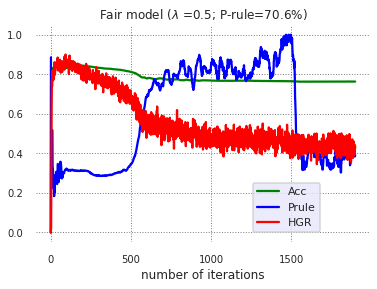

<Figure size 432x432 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
filter  = 0
iter = range(table[filter:].shape[0])
ACC = table[:,0]
PRULE = table[:,1]
HGR = table[:,2]

fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.plot(iter, ACC/100, color = 'green',label="Acc")
ax1.plot(iter, PRULE, color = 'blue',label="Prule")
ax1.plot(iter, HGR, color = 'red',label="HGR")
#leg = plt.legend(loc="best", edgecolor="gray",facecolor="gray")
#plt.ylim(0,25)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.xlabel("number of iterations", fontsize=12)
#plt.ylabel("P(f(X))", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.3),shadow=False, ncol=1, fontsize=11,facecolor='lavender')
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betamse) + '; P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) +'%)', fontsize=12)
fig.savefig("Trainingcurves3_lam" + str(betamse)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')
fig.savefig("/content/drive/MyDrive/Withoutdemo/Trainingcurves3_lam" + str(betamse)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')

plt.show()
plt.clf() 


<Figure size 432x432 with 0 Axes>

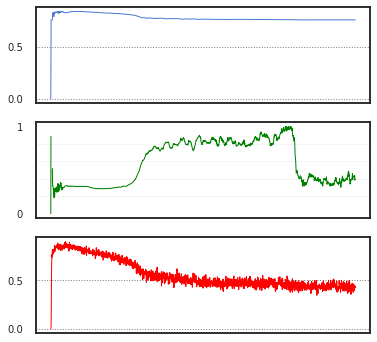

In [ ]:
display.clear_output(wait=True)
display.display(plt.gcf())

ax1 = plt.subplot(311)   
ax1.set_facecolor('white')
ax1.grid(color='gray',which='major', linestyle=':', linewidth=1)
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
values = np.array(ACC/100)
plt.plot(range(len(values)), values, label=r"$L_f$",linewidth=1, markersize=12)
#plt.legend(loc="upper right")

ax2 = plt.subplot(312, sharex=ax1) 
ax2.set_facecolor('white')
ax2.grid(color='gray',which='minor' ,linestyle=':', linewidth=1,alpha=0.2)
ax2.minorticks_on()
x_axis2 = ax2.axes.get_xaxis()
x_axis2.set_visible(False)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
values = np.array(PRULE) 
plt.plot(range(len(values)), values, label=r"$L_r$", color="green",linewidth=1, markersize=12)
#plt.legend(loc="upper right")

ax3 = plt.subplot(313, sharex=ax1)
ax3.set_facecolor('white')
ax3.grid(color='gray', linestyle=':', linewidth=1)
x_axis3 = ax3.axes.get_xaxis()
x_axis3.set_visible(False)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
values = np.array(HGR)
plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red",linewidth=1, markersize=12)
#plt.legend(loc="upper right")

plt.show()

In [ ]:
import matplotlib.pyplot as plt 
plt.rcdefaults()

In [ ]:
values[-10:]

array([0.39381546, 0.45449409, 0.43231779, 0.43505356, 0.39373755,
       0.41253573, 0.42374054, 0.4421421 , 0.42375019, 0.43624443])

In [ ]:
values

array([0.        , 0.01053887, 0.02328468, ..., 0.4421421 , 0.42375019,
       0.43624443])

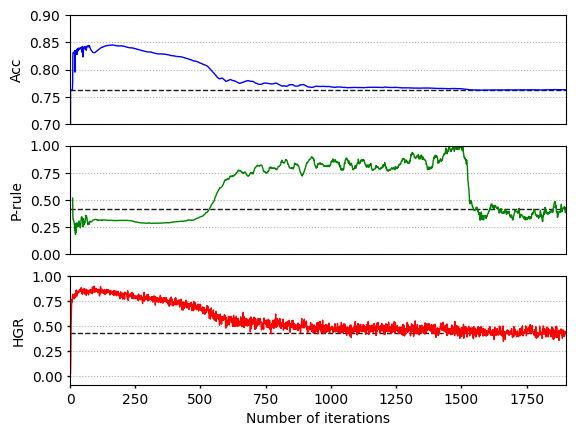

In [ ]:
    import matplotlib.pyplot as plt
    from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
    ax1 = plt.subplot(311)  
    values = np.array(ACC/100)
    plt.plot(range(len(values)), values, color="blue",linewidth=1, markersize=12)
    plt.grid(True)  
    ax1.spines.linewidth=0
    min_Lf=np.mean(values[-2:])
    n_iter=ACC.shape[0]
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed",linewidth=1)
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    #high = high - (high-low) * 0.3
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(0.7, 0.9)
    plt.xticks([])
    plt.xlim(0, n_iter)
    ax1.yaxis.set_major_locator(MultipleLocator(0.05))
    plt.grid(True, linestyle='dotted')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.ylabel(r"Acc", fontsize=10)
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = PRULE 
    plt.plot(range(len(values)), values, color="green",linewidth=1, markersize=12)  
    min_Lf=np.mean(values[-20:])
    n_iter=ACC.shape[0]
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed",linewidth=1)
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    #high = high - (high-low) * 0.3
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(0, 1)
    plt.xticks([])
    plt.xlim(0, n_iter)
    ax2.yaxis.set_major_locator(MultipleLocator(0.25))
    plt.grid(True, linestyle='dotted')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel(r"P-rule", fontsize=10)
    
    ax3 = plt.subplot(313)
    values = np.array(HGR)
    plt.plot(range(len(values)), values, color="red",linewidth=1, markersize=12)  
    min_Lf=np.mean(values[-10:])
    n_iter=ACC.shape[0]
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed",linewidth=1)
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    #low = low + (high-low) * 0.5
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, 1)
    plt.xlim(0, n_iter)
    ax3.yaxis.set_major_locator(MultipleLocator(0.25))
    plt.grid(axis="y", linestyle='dotted')
    plt.ylabel("HGR", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Number of iterations", fontsize=10)
    ax3.tick_params(direction='out', length=2, width=1,
                grid_alpha=1)
plt.rcParams["font.size"] = 10
plt.savefig("Trainingcurves3_lam" + str(betamse)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')
plt.savefig("/content/drive/MyDrive/Withoutdemo/Trainingcurves3_lam" + str(betamse)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')


In [ ]:
data1 = y_pred[100:,1]
data2 = y_pred[100:,3]
t = range(281)
fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
color = 'tab:blue'
ax1.set_xlabel('number of iterations')
ax1.set_ylim(0.5, 1)
ax1.set_ylabel('Classification accuracy %', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.grid(color='gray', linestyle=':', linewidth=1)
ax2.set_ylabel('p%-rule %', color=color)  # we already handled the x-label with ax1
ax2.set_ylim(0.5, 1)
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Unfair model (FAGTB with $\lambda$=%1.3f)"  %lamb)
plt.show()
val = 0

NameError: ignored

In [ ]:
ACC.mean()

79.3749521402005

In [ ]:
ACC.mean()

79.3749521402005

tensor(0.6086, device='cuda:0')


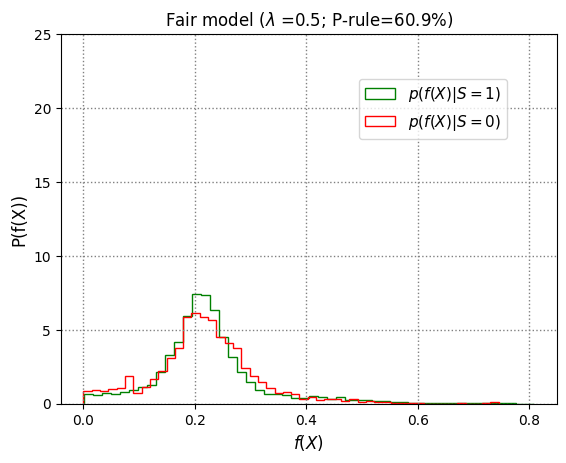

<Figure size 600x600 with 0 Axes>

In [ ]:
Ypredtest = torch.sigmoid(model_Y(torch.cat([XNC_testCUDA.view(-1, 43),X_testCUDA.view(-1, 53)],1)))>0.5
Ho = (S_test==1)
Fe = (S_test==0)
odds=Ypredtest.float()[Ho].mean()/ Ypredtest.float()[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest = torch.sigmoid(model_Y(torch.cat([XNC_testCUDA.view(-1, 43),X_testCUDA.view(-1, 53)],1)))

fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.hist(Ypredtest.float()[Ho].cpu().data.numpy(), color = 'green',bins=50, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(Ypredtest.float()[Fe].cpu().data.numpy(), color = 'red',bins=50, density=1,histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,25)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$f(X)$", fontsize=12)
plt.ylabel("P(f(X))", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.9),shadow=False, ncol=1, fontsize=11)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betamse) + '; P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) +'%)', fontsize=12)
fig.savefig("Test_distrib25_lam" + str(betamse)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')
fig.savefig("/content/drive/MyDrive/Withoutdemo/Test_distrib_lam" + str(betamse)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')

plt.show()
plt.clf() 



tensor(0.6086, device='cuda:0')


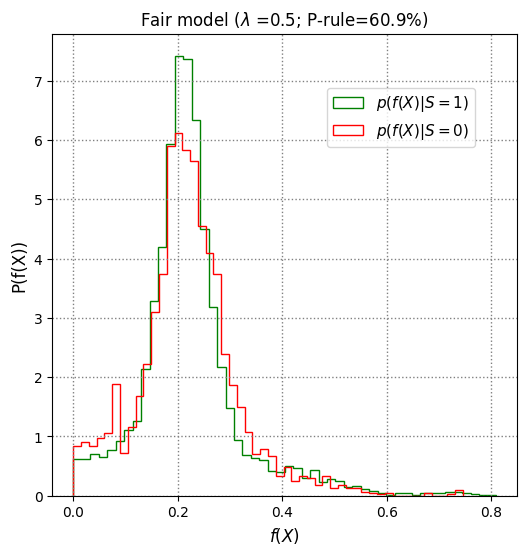

<Figure size 600x600 with 0 Axes>

In [ ]:
Ypredtest = torch.sigmoid(model_Y(torch.cat([XNC_testCUDA.view(-1, 43),X_testCUDA.view(-1, 53)],1)))>0.5
Ho = (S_test==1)
Fe = (S_test==0)
odds=Ypredtest.float()[Ho].mean()/ Ypredtest.float()[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest = torch.sigmoid(model_Y(torch.cat([XNC_testCUDA.view(-1, 43),X_testCUDA.view(-1, 53)],1)))

fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.hist(Ypredtest.float()[Ho].cpu().data.numpy(), color = 'green',bins=50, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(Ypredtest.float()[Fe].cpu().data.numpy(), color = 'red',bins=50, density=1,histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
#plt.ylim(0,25)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$f(X)$", fontsize=12)
plt.ylabel("P(f(X))", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.9),shadow=False, ncol=1, fontsize=11)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betamse) + '; P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) +'%)', fontsize=12)
fig.savefig("Test_distrib_lam" + str(betamse)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')
fig.savefig("/content/drive/MyDrive/Withoutdemo/Test_distrib_lam" + str(betamse)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')

plt.show()
plt.clf() 


In [ ]:
Ypred = torch.sigmoid(model_Y(torch.cat([XNC_trainCUDA.view(-1, 43),X_trainCUDA.view(-1, 53)],1)))>0.5
Ho = (S_train==1)
Fe = (S_train==0)
odds=Ypred.float()[Ho].mean()/ Ypred.float()[Fe].mean()
PRULE= min(odds, 1/odds)
print('Prule Train: ', PRULE)

Prule Train:  tensor(0.6504, device='cuda:0')


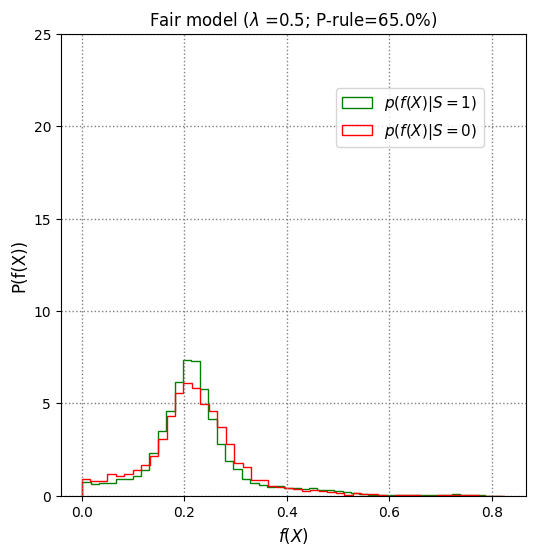

<Figure size 600x600 with 0 Axes>

In [ ]:
Ypred = torch.sigmoid(model_Y(torch.cat([XNC_trainCUDA.view(-1, 43),X_trainCUDA.view(-1, 53)],1)))
Ho = (S_train==1)
Fe = (S_train==0)
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.hist(Ypred.float()[Ho].cpu().data.numpy(), color = 'green',bins=50, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(Ypred.float()[Fe].cpu().data.numpy(), color = 'red',bins=50, density=1,histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best", edgecolor="gray",facecolor="gray")
plt.ylim(0,25)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$f(X)$", fontsize=12)
plt.ylabel("P(f(X))", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.9),shadow=False, ncol=1, fontsize=11)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betamse) + '; P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) +'%)', fontsize=12)
fig.savefig("Train_distrib25_lam" + str(betamse)+ 'P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) + '.pdf')
fig.savefig("/content/drive/MyDrive/Withoutdemo/Train_distrib_lam" + str(betamse)+ 'P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) + '.pdf')

plt.show()
plt.clf() 

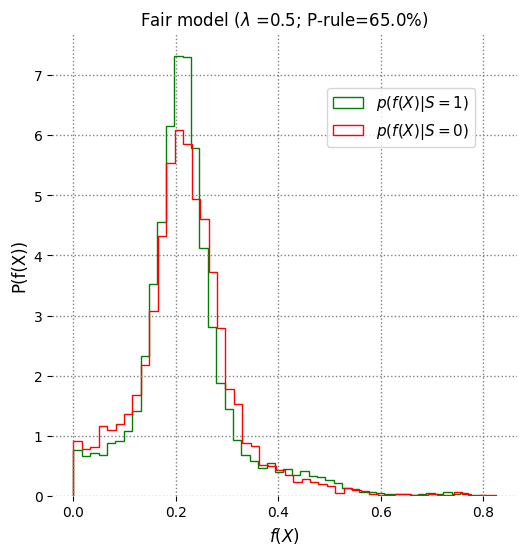

<Figure size 600x600 with 0 Axes>

In [ ]:
PRULEYpred = torch.sigmoid(model_Y(torch.cat([XNC_trainCUDA.view(-1, 43),X_trainCUDA.view(-1, 53)],1)))
Ho = (S_train==1)
Fe = (S_train==0)
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.hist(Ypred.float()[Ho].cpu().data.numpy(), color = 'green',bins=50, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(Ypred.float()[Fe].cpu().data.numpy(), color = 'red',bins=50, density=1,histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best", edgecolor="gray",facecolor="gray")
#plt.ylim(0,25)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.xlabel("$f(X)$", fontsize=12)
plt.ylabel("P(f(X))", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.9),shadow=False, ncol=1, fontsize=11)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betamse) + '; P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) +'%)', fontsize=12)
fig.savefig("Train_distrib_lam" + str(betamse)+ 'P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) + '.pdf')
fig.savefig("/content/drive/MyDrive/Withoutdemo/Train_distrib_lam" + str(betamse)+ 'P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) + '.pdf')


plt.show()
plt.clf() 



In [ ]:
Ypred.float()[Ho]

tensor([0.3150, 0.2081, 0.2454,  ..., 0.1725, 0.1688, 0.1893], device='cuda:0',
       grad_fn=<IndexBackward>)

In [ ]:
import sys

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
nb_a=1
Sreal = Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).repeat(nb_a,1).data.numpy()
recon_x, S, recon_y, mu, logvar = model(X_trainCUDA.repeat(nb_a,1).view(-1, 53), XNC_trainCUDA.repeat(nb_a,1).view(-1, 43), y_trainCUDA.repeat(nb_a,1).view(-1, 1))
reg.fit (S.cpu().data.numpy(), Sreal)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Sreal, (((reg.predict(S.cpu().data.numpy()).astype('uint8'))>0.5)))

0.829161547911548

In [ ]:
# lambda = 0
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
print("HGR NN Test",HGR_NNP(Variable(torch.FloatTensor(S.cpu().data.numpy())) , Variable(torch.FloatTensor(Sreal)).repeat(nb_a,1).view(-1, 1),100))


HGR NN Test 0.9576497


In [ ]:
data_subset=S.cpu().data.numpy().copy()

In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 39072 samples in 0.026s...
[t-SNE] Computed neighbors for 39072 samples in 3.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 39072
[t-SNE] Computed conditional probabilities for sample 2000 / 39072
[t-SNE] Computed conditional probabilities for sample 3000 / 39072
[t-SNE] Computed conditional probabilities for sample 4000 / 39072
[t-SNE] Computed conditional probabilities for sample 5000 / 39072
[t-SNE] Computed conditional probabilities for sample 6000 / 39072
[t-SNE] Computed conditional probabilities for sample 7000 / 39072
[t-SNE] Computed conditional probabilities for sample 8000 / 39072
[t-SNE] Computed conditional probabilities for sample 9000 / 39072
[t-SNE] Computed conditional probabilities for sample 10000 / 39072
[t-SNE] Computed conditional probabilities for sample 11000 / 39072
[t-SNE] Computed conditional probabilities for sample 12000 / 39072
[t-SNE] Computed conditional probabilities for sa

In [ ]:
df_subset=pd.DataFrame(data_subset)

In [ ]:
df_subset['gender']=Sreal

In [ ]:
df_subset.shape

(39072, 4)

In [ ]:
Ypred = torch.sigmoid(model_Y(torch.cat([XNC_trainCUDA.view(-1, 43),X_trainCUDA.view(-1, 53)],1)))>0.5
Ho = (S_train==1)
Fe = (S_train==0)
odds=Ypred.float()[Ho].mean()/ Ypred.float()[Fe].mean()
PRULE= min(odds, 1/odds)
print('Prule Train: ', PRULE)

Prule Train:  tensor(0.5496, device='cuda:0')


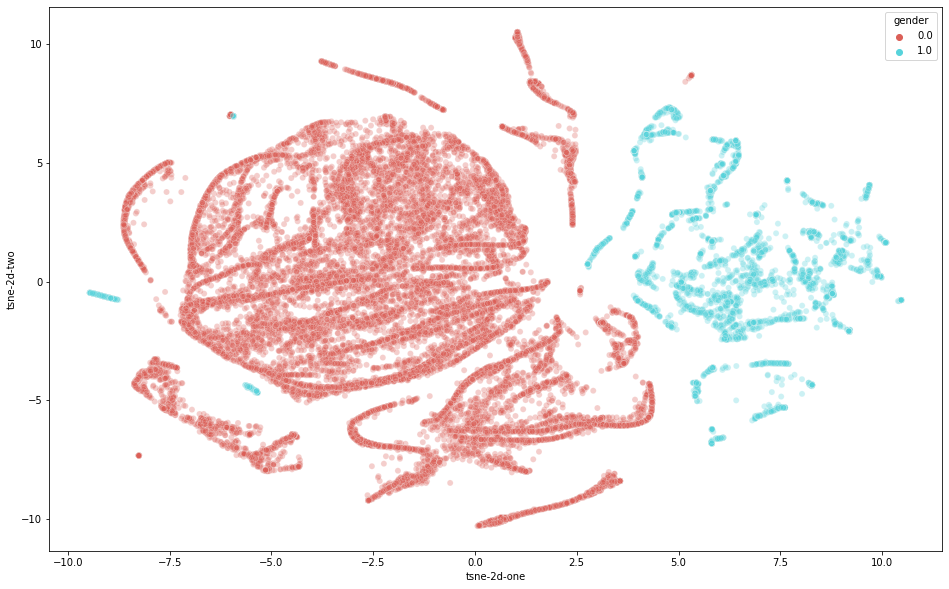

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns_plot =sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="gender",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

sns_plot.figure.savefig("output.png")
fig.savefig("/content/drive/MyDrive/Withoutdemo/T-sne" + str(betamse)+ 'P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) + '.pdf')


In [ ]:
PRULE

array([0.        ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.        , 0.2775946 ,
       0.28424612, 0.28865653, 0.33412871, 0.22280854, 0.28902996,
       0.33179486, 0.26872152, 0.30968815, 0.3386094 , 0.30131939,
       0.31342563, 0.35935465, 0.36441863, 0.31287634, 0.34514073,
       0.36903113, 0.34796748, 0.32875741, 0.36137515, 0.36669859,
       0.32575786, 0.32196835, 0.32533622, 0.28924185, 0.29316339,
       0.33839849, 0.31146118, 0.3156938 , 0.34069297, 0.33066264,
       0.31225598, 0.33546215, 0.35110551, 0.31229088, 0.30015412,
       0.31061718, 0.29680961, 0.28458568, 0.26871425, 0.26782784,
       0.26845959, 0.26378313, 0.28578424, 0.27579647, 0.26934424,
       0.28808475, 0.29514778, 0.27868778, 0.29491821, 0.28039461,
       0.29181814, 0.31813151, 0.28641957, 0.29163474, 0.30354738,
       0.29006061, 0.33576369, 0.31302273, 0.27535585, 0.29117459,
       0.30265778, 0.27907369, 0.27622139, 0.27396277, 0.27520

In [ ]:
Variable(torch.FloatTensor(S.cpu().data.numpy())).shape

torch.Size([39072, 5])

In [ ]:
reg.predict(S.cpu().data.numpy())>0.5

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [ ]:
S.cpu().data.numpy().shape

(102400, 5)

In [ ]:
table.shape

(757, 4)

In [ ]:
((np.mean(ytrain)-ytrain)**2).mean()

0.18123342116546975

In [ ]:
optimizer_F.step()
optimizer_G.step()

In [ ]:
x_var.repeat(2,1).view(-1, 53)[512,:]

tensor([0.1038, 0.8667, 0.0000, 0.0000, 0.4286, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')

In [ ]:
recon_x.view(-1, 53)[512,:]

tensor([1.1372e-01, 9.4376e-01, 3.7464e-02, 5.1506e-02, 4.6568e-01, 6.8853e-04,
        7.0738e-06, 9.9365e-01, 1.7038e-03, 3.3817e-04, 7.0279e-03, 7.6302e-06,
        4.2219e-05, 6.7876e-08, 1.9976e-04, 4.4793e-04, 1.1422e-04, 2.0017e-05,
        3.9951e-05, 7.9316e-04, 4.2150e-04, 4.8491e-04, 1.0855e-02, 2.2881e-06,
        9.9103e-01, 1.0416e-04, 1.8059e-02, 4.7201e-03, 4.6958e-05, 9.8309e-01,
        2.4383e-03, 1.8188e-04, 1.6986e-04, 2.9051e-04, 4.8375e-05, 4.1403e-05,
        1.1247e-04, 3.2112e-08, 1.1689e-04, 1.6853e-04, 1.5927e-06, 8.7486e-04,
        9.9372e-01, 1.5026e-03, 1.0383e-04, 8.3573e-03, 1.1785e-02, 1.1206e-05,
        3.0427e-04, 4.5111e-05, 3.0104e-03, 1.0166e-02, 3.7463e-03],
       device='cuda:0', grad_fn=<SliceBackward>)

In [ ]:
batch_size = 512
num_epochs = 2000
learning_rate = 0.0001
batch_no = len(X_train) // batch_size
#X_train_inv = recon_X_batch_a.data.numpy()
#Y_train_inv = recon_Y_batch_a.data.numpy()

from sklearn.utils import shuffle
from torch.autograd import Variable
criterionMSE = nn.MSELoss()
import math
nb_a=200
from torch.nn import functional as F
def sigmoid(x):
  output = [1 / (1 + math.exp(-x)) for x in x]
  return output

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(96, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x
class ADV(nn.Module):
    def __init__(self):
        super(ADV, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x
table = [0,0,0,0]
model_Y = NN().cuda()
model_ADV = ADV().cuda()
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer_Y = torch.optim.Adam(model_Y.parameters(), lr=0.001)
criterion_ADV =  nn.MSELoss()
optimizer_ADV = torch.optim.Adam(model_ADV.parameters(), lr=learning_rate)
#A0 = sensitive.mean() + sensitive.std()*Variable(torch.randn(data.shape[0]*nb_a, 1),requires_grad=False)
#recon_X_batch_a0, z_a0, recon_Y_batch_a0, mu_a0, logvar_a0 = model(data.repeat(nb_a,1).view(-1, 33),A0)
#recon_x, recon_xNC, S, U,  recon_y, mu, logvar = model(x_var, x_varNC, y_var,s_var)
from sklearn.metrics import accuracy_score
X_trainCUDA = Variable(torch.FloatTensor(X_train)).cuda()
XNC_trainCUDA = Variable(torch.FloatTensor(XNC_train)).cuda()
y_trainCUDA = Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).cuda()

for epoch in range(num_epochs):
    #if epoch % 50 != 0:
        #x_train = Variable(torch.FloatTensor(X_train.values),requires_grad=True)
        #x_test = Variable(torch.FloatTensor(X_test.values),requires_grad=True)
        #print('Epoch {}'.format(epoch+1))
        
        #y_predX= model(x_train).data.numpy().T
        #y_predXinv= model(recon_X_batch_a0).data.numpy().T

        #accuracy = (y_train-np.squeeze(y_predX)).pow(2).sum()     
        #accuracycount = accuracy_score(Y_train_inv.squeeze(1), np.squeeze(y_predXinv))
        #print ("Train Accuracy:", accuracy)#,"Train Accuracy Count:", accuracycount, "CLP:", np.mean(logit_y_predX-logit_y_predXinv)**2)
    x_train, x_trainNC, ytrain, sens_train = shuffle(X_train, XNC_train, np.expand_dims(y_train,axis = 1),  S_train)
    #A = s_var.mean() + s_var.std()*Variable(torch.randn(batch_size*nb_a, 1),requires_grad=False)
    # Mini batch learning
    for i in range(batch_no):
        print(i)
        start = i * batch_size
        end = start + batch_size

        x_var = Variable(torch.FloatTensor(x_train[start:end])).cuda()
        xNC_var = Variable(torch.FloatTensor(x_trainNC[start:end])).cuda()
        y_var = Variable(torch.FloatTensor(ytrain[start:end])).cuda()
        s_var = Variable(torch.FloatTensor(sens_train[start:end])).cuda()

        #recon_X_batch_a, z_a, recon_Y_batch_a, mu_a, logvar_a = model(x_var.repeat(nb_a,1).view(-1, 53),x_var.repeat(nb_a,1).view(-1, 33))
        recon_x, recon_xNC, S, U,  recon_y, mu, logvar = model(x_var.repeat(nb_a,1).view(-1, 53), xNC_var.repeat(nb_a,1).view(-1, 43), y_var.repeat(nb_a,1).view(-1, 1),s_var.repeat(nb_a,1).view(-1, 1))

        optimizer_Y.zero_grad()
        ypred_var = model_Y(torch.cat([xNC_var.view(-1, 43),x_var.view(-1, 53)],1))
        lossY =criterion(ypred_var, y_var)

        ypredcontworld = model_Y(torch.cat([recon_xNC.view(-1, 43),recon_x.view(-1, 53)],1))
        lossX_inv = criterion(ypredcontworld, recon_y)

        ypred2= ypredcontworld.detach()
        for k in range(10):
          optimizer_ADV.zero_grad()
          ypred_ADV = model_ADV(ypred2)
          lossX =criterion_ADV(ypred_ADV,S)
          optimizer_ADV.step()
        #Yhat_count =  Variable(torch.FloatTensor(ypred_var.data.numpy().T.repeat(nb_a,1).T))
        #MSEcount = (Yhat_count-ypredcontworld).pow(2).sum() 
        
        betamse =300.0
        ypred_ADV = model_ADV(ypred2)
        lossX =criterion_ADV(ypred_ADV,s_var.repeat(nb_a,1).view(-1, 1))
        loss = lossY -betamse*lossX # + lossX_inv -2*lossX#+ betamse*MSEcount
        print(loss)
        print(lossX)
        loss.backward()
        optimizer_Y.step()
        Ypred = torch.sigmoid(model_Y(torch.cat([XNC_trainCUDA.view(-1, 43),X_trainCUDA.view(-1, 53)],1)))>0.5
        Ho = (S_train==1)
        Fe = (S_train==0)
        odds=Ypred.float()[Ho].mean()/ Ypred.float()[Fe].mean()
        PRULE= min(odds, 1/odds)
        print('ACC',(Ypred==y_trainCUDA).sum()/X_train.shape[0], 'PRULE',PRULE)
        table = np.vstack([table,[(Ypred==y_trainCUDA).sum()/X_train.shape[0]*100,PRULE,Res['DispFPR'],Res['DispFNR']]])
np.savetxt(sys.stdout, np.mean(table[1:,], axis=0).astype(float), '%5.2f')


0
tensor(-206.1055, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6894, device='cuda:0', grad_fn=<MseLossBackward>)
ACC tensor(0.2378, device='cuda:0') PRULE tensor(1., device='cuda:0')
1
tensor(-197.5755, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6610, device='cuda:0', grad_fn=<MseLossBackward>)
ACC tensor(0.2378, device='cuda:0') PRULE tensor(1., device='cuda:0')
2
tensor(-215.7894, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.7217, device='cuda:0', grad_fn=<MseLossBackward>)
ACC tensor(0.2378, device='cuda:0') PRULE tensor(1., device='cuda:0')
3
tensor(-215.1595, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.7196, device='cuda:0', grad_fn=<MseLossBackward>)
ACC tensor(0.2378, device='cuda:0') PRULE tensor(1., device='cuda:0')
4
tensor(-196.2959, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6567, device='cuda:0', grad_fn=<MseLossBackward>)
ACC tensor(0.2378, device='cuda:0') PRULE tensor(1., device='cuda:0')
5
tensor(-197.4915, device='cuda:0', grad_fn=<SubB

KeyboardInterrupt: ignored

tensor([[-4.4928,  6.4100,  0.4568,  0.3463, -0.6158],
        [-6.5117,  0.7561, -3.5439, -0.9248, -5.9962],
        [-2.1233, -1.4062,  0.4550, -0.3655, -5.0423],
        ...,
        [-0.8465,  3.3012, -4.0236, -3.1975, -0.0640],
        [-6.7243, -0.5177, -1.8809, -1.2876, -2.2849],
        [ 0.5550, -0.4949,  5.2409,  1.7638,  2.3707]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit (S, [0, 1, 2])

In [ ]:
S

tensor([[ 0.4173],
        [-0.6840],
        [-0.8557],
        ...,
        [-1.7567],
        [-3.0534],
        [ 3.2146]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
Ypred

tensor([[ True],
        [False],
        [False],
        ...,
        [False],
        [ True],
        [False]], device='cuda:0')

tensor(0.2951, device='cuda:0')

In [ ]:
def p_rule(y_pred, z_values, threshold=0.5):
    
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [ ]:
max(Ypred[H].float().mean()/Ypred[F].float().mean(), Ypred[F].float().mean()/Ypred[H].float().mean())

tensor(3.3888, device='cuda:0')

In [ ]:
(Ypred==y_trainCUDA).shape

torch.Size([39072, 1])

In [ ]:
(Ypred==)

tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]], device='cuda:0')

In [ ]:
Ypred

tensor([[0.9672],
        [0.9543],
        [0.9609],
        ...,
        [0.9531],
        [0.9504],
        [0.9477]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
X_trainCUDA.view(-1, 53)

tensor([[0.0948, 0.8000, 0.1434,  ..., 0.0000, 1.0000, 0.0000],
        [0.0983, 0.6000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3557, 0.8000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1180, 0.6000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0704, 0.8000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1481, 0.5333, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
x_var.repeat(nb_a,1).view(-1, 53).shape

torch.Size([102400, 53])

In [ ]:
x_varNC.repeat(nb_a,1).view(-1, 43).shape

torch.Size([400000, 43])

In [ ]:
y_var.repeat(nb_a,1).view(-1, 1).shape

torch.Size([102400, 1])

In [ ]:
s_var.repeat(nb_a,1).view(-1, 1).shape

torch.Size([102400, 1])

In [ ]:
nb_a

200

In [ ]:
from sklearn.utils import shuffle
from torch.autograd import Variable
import math

batch_size = 512
num_epochs = 2000
learning_rate = 0.0001
batch_no = len(X_train) // batch_size
X_train_inv = recon_X_batch.data.numpy()
Y_train_inv = recon_Y_batch.data.numpy()
Y_train_inv = (Y_train_inv>0.5)*1
criterionMSE = nn.MSELoss()

def sigmoid(x):
  output = [1 / (1 + math.exp(-x)) for x in x]
  return output

class encodeder(nn.Module):
    def __init__(self):
        super(encodeder, self).__init__()
        self.fc1 = nn.Linear(33, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

class NN_y(nn.Module):
    def __init__(self):
        super(NN_y, self).__init__()
        self.fc1_y = nn.Linear(16, 8)
        self.fc2_y = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc1_y(x)
        x = torch.relu(x)
        x = self.fc2_y(x)
        return x

class NN_s(nn.Module):
    def __init__(self):
        super(NN_s, self).__init__()
        self.fc1_s = nn.Linear(16, 8)
        self.fc2_s = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc1_s(x)
        x = torch.relu(x)
        x = self.fc2_s(x)
        return x
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')

m_encodeder = encodeder()
m_NN_y = NN_y()
m_NN_s = NN_s()

optimizer_enc = torch.optim.Adam(m_encodeder.parameters(), lr=learning_rate)
optimizer_y = torch.optim.Adam(m_NN_y.parameters(), lr=learning_rate)
optimizer_s = torch.optim.Adam(m_NN_s.parameters(), lr=learning_rate)

lambda_ADV = 10
for epoch in range(num_epochs):
    x_train, x_trainNC, ytrain, senstrain = shuffle(X_train, XNC_train , np.expand_dims(y_train,axis = 1), S_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train[start:end]))
        x_trainNC = Variable(torch.FloatTensor(x_trainNC[start:end]))
        y_var = Variable(torch.FloatTensor(ytrain[start:end]))
        s_var = Variable(torch.FloatTensor(sens_train[start:end]))

        optimizer.zero_grad()
        for k in range(50):
          optimizer_y.zero_grad()
          optimizer_s.zero_grad() 
          Z= m_encodeder(x_var)
          Spred_var = m_NN_y(Z)
          Ypred_var = m_NN_s(Z)
          lossS =criterion(Spred_var, s_var)
          lossY =criterion(Ypred_var, y_var)
          lossS.backward(retain_graph=True)
          lossY.backward(retain_graph=True)
          optimizer_y.step()
          optimizer_s.step()

        Spred_var = m_NN_y(Z)
        Ypred_var = m_NN_s(Z)
        lossS =criterion(Spred_var, s_var)
        lossY =criterion(Ypred_var, y_var)

        loss = - lambda_ADV*lossS + lossY 

        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
      print('epoch', epoch,'loss',loss.data.numpy(),'lossS',lossS.data.numpy(),'lossY',lossY.data.numpy())

KeyboardInterrupt: ignored

In [ ]:
y_pred = clf.predict(X_test).squeeze(1)

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
H = 15
H2 = 15


class Net_HGR(nn.Module):
    def __init__(self):
        super(Net_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


class Net2_HGR(nn.Module):
    def __init__(self):
        super(Net2_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


model_Net_F = Net_HGR()
model_Net_G = Net2_HGR()


class HGR_NN(nn.Module):
    
    def __init__(self,model_F,model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_Net_F
        self.mG = model_Net_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var,nb):
      
        for j in range(nb) :
            #ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
            #ret = torch.mean(pred_xy) - torch.mean(pred_x_y) - 0.25*torch.mean(torch.pow(pred_x_y,2))

            yhat2  =yhat.data.numpy()
            y2_var2=y2_var.data.numpy()
        
            yhat2_PT  = torch.from_numpy(yhat2).type(torch.FloatTensor)
            y2_var_PT = torch.from_numpy(y2_var2).type(torch.FloatTensor)

            pred_F  = self.mF(yhat2_PT)
            pred_G  = self.mG(y2_var_PT)

            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.std(pred_F)
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.std(pred_G)

            #epsilon=0.0000000000000000001
            epsilon=0.0001 
            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
            pred_F_norm[torch.isnan(pred_F_norm )] = 0
            pred_G_norm[torch.isnan(pred_G_norm )] = 0

            ret = torch.mean(pred_F_norm*pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            #print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret.data.numpy()

In [ ]:
y_pred = pd.Series(clf.predict(X_test).squeeze(1))

In [ ]:
# lambda = 0
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
print("HGR NN Test",HGR_NNP(torch.FloatTensor(y_pred).unsqueeze(1) , torch.FloatTensor(Z_test).unsqueeze(1),10000))
print(f"Accuracy: {np.mean((y_test-y_pred)**2)}%")

HGR NN Test 0.2241652
Accuracy: 0.9594637821755506%


In [ ]:
from sklearn.utils import shuffle
from torch.autograd import Variable
import math

batch_size = 512
num_epochs = 2000
learning_rate = 0.0001
batch_no = len(X_train) // batch_size
X_train_inv = recon_X_batch.data.numpy()
Y_train_inv = recon_Y_batch.data.numpy()
Y_train_inv = (Y_train_inv>0.5)*1
criterionMSE = nn.MSELoss()

def sigmoid(x):
  output = [1 / (1 + math.exp(-x)) for x in x]
  return output

class encodeder(nn.Module):
    def __init__(self):
        super(encodeder, self).__init__()
        self.fc1 = nn.Linear(33, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

class NN_y(nn.Module):
    def __init__(self):
        super(NN_y, self).__init__()
        self.fc1_y = nn.Linear(16, 8)
        self.fc2_y = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc1_y(x)
        x = torch.relu(x)
        x = self.fc2_y(x)
        return x

class NN_s(nn.Module):
    def __init__(self):
        super(NN_s, self).__init__()
        self.fc1_s = nn.Linear(16, 8)
        self.fc2_s = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc1_s(x)
        x = torch.relu(x)
        x = self.fc2_s(x)
        return x
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')

m_encodeder = encodeder()
m_NN_y = NN_y()
m_NN_s = NN_s()

optimizer_enc = torch.optim.Adam(m_encodeder.parameters(), lr=learning_rate)
optimizer_y = torch.optim.Adam(m_NN_y.parameters(), lr=learning_rate)
optimizer_s = torch.optim.Adam(m_NN_s.parameters(), lr=learning_rate)

lambda_ADV = 10
for epoch in range(num_epochs):
    x_train, ytrain, sens_train = shuffle(X_train, np.expand_dims(y_train,axis = 1), np.expand_dims(Z_train,axis = 1))
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train[start:end]))
        y_var = Variable(torch.FloatTensor(ytrain[start:end]))
        s_var = Variable(torch.FloatTensor(sens_train[start:end]))

        optimizer.zero_grad()
        for k in range(50):
          optimizer_y.zero_grad()
          optimizer_s.zero_grad() 
          Z= m_encodeder(x_var)
          Spred_var = m_NN_y(Z)
          Ypred_var = m_NN_s(Z)
          lossS =criterion(Spred_var, s_var)
          lossY =criterion(Ypred_var, y_var)
          lossS.backward(retain_graph=True)
          lossY.backward(retain_graph=True)
          optimizer_y.step()
          optimizer_s.step()

        Spred_var = m_NN_y(Z)
        Ypred_var = m_NN_s(Z)
        lossS =criterion(Spred_var, s_var)
        lossY =criterion(Ypred_var, y_var)

        loss = - lambda_ADV*lossS + lossY 

        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
      print('epoch', epoch,'loss',loss.data.numpy(),'lossS',lossS.data.numpy(),'lossY',lossY.data.numpy())# HIDE
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    legend={'race': ['black','white'],
            'sex': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.distplot(y[Z[attr] == attr_val], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format(legend[attr][attr_val]), 
                              ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    return fig

In [ ]:
fig = plot_distributions(y_pred, Z_test, fname='biased_training.png') 

NameError: ignored

In [ ]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [ ]:
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

The classifier satisfies the following %p-rules:


IndexError: ignored